In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
import cv2
import json
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
batch_size = 40
img_height = 200
img_width = 200

In [22]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../input/maskdataset/dataset/dataset',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 1376 files belonging to 2 classes.
Using 1101 files for training.


In [23]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'../input/maskdataset/dataset/dataset',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 1376 files belonging to 2 classes.
Using 275 files for validation.


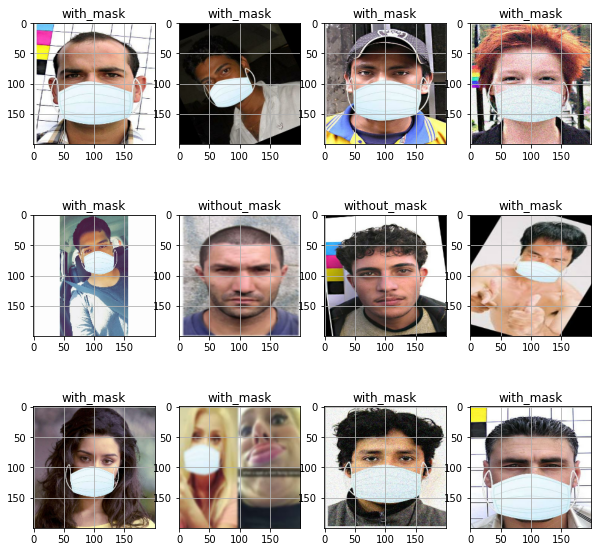

In [24]:
class_names = training_ds.class_names
num_classes  = training_ds.cardinality
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
tf.random.set_seed(42)

In [33]:
model=Sequential()
model.add(Conv2D(64,(3,3),input_shape=(200,200,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 198, 198, 64)      1792      
_________________________________________________________________
activation_6 (Activation)    (None, 198, 198, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 97, 97, 128)       73856     
_________________________________________________________________
activation_7 (Activation)    (None, 97, 97, 128)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 294912)           

In [34]:
earlystop = EarlyStopping(patience=4,monitor="val_loss",)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.9, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [35]:
epoch=50
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=Adam(learning_rate=0.0001),
             metrics=['accuracy'])

In [36]:
retVal = model.fit(training_ds, validation_data= testing_ds, epochs = 50,
                            callbacks=callbacks,shuffle=True)

Epoch 1/50
28/28 [==============================] - 4s 101ms/step - loss: 57.4794 - accuracy: 0.5804 - val_loss: 2.7464 - val_accuracy: 0.8764
Epoch 2/50
28/28 [==============================] - 3s 102ms/step - loss: 2.6189 - accuracy: 0.8747 - val_loss: 0.8584 - val_accuracy: 0.9091
Epoch 3/50
28/28 [==============================] - 3s 92ms/step - loss: 0.5324 - accuracy: 0.9401 - val_loss: 0.2504 - val_accuracy: 0.9636
Epoch 4/50
28/28 [==============================] - 3s 93ms/step - loss: 0.1871 - accuracy: 0.9673 - val_loss: 0.1909 - val_accuracy: 0.9709
Epoch 5/50
28/28 [==============================] - 3s 102ms/step - loss: 0.1509 - accuracy: 0.9728 - val_loss: 0.2167 - val_accuracy: 0.9709
Epoch 6/50
28/28 [==============================] - 3s 92ms/step - loss: 0.1359 - accuracy: 0.9709 - val_loss: 0.4828 - val_accuracy: 0.9382

Epoch 00006: ReduceLROnPlateau reducing learning rate to 8.999999772640876e-05.
Epoch 7/50
28/28 [==============================] - 3s 98ms/step - lo

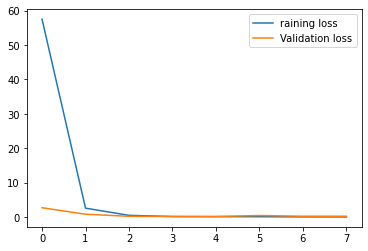

In [37]:
plt.plot(retVal.history['loss'], label = 'raining loss')
plt.plot(retVal.history['val_loss'], label = 'Validation loss')
plt.legend()

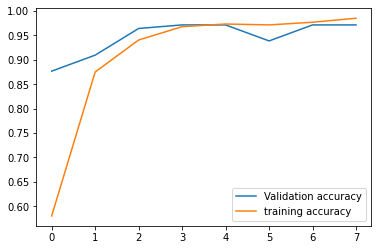

In [38]:
plt.plot(retVal.history['val_accuracy'], label = 'Validation accuracy')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

In [39]:
model.evaluate(testing_ds)

7/7 [==============================] - 1s 20ms/step - loss: 0.2771 - accuracy: 0.9709


[0.277107834815979, 0.9709091186523438]

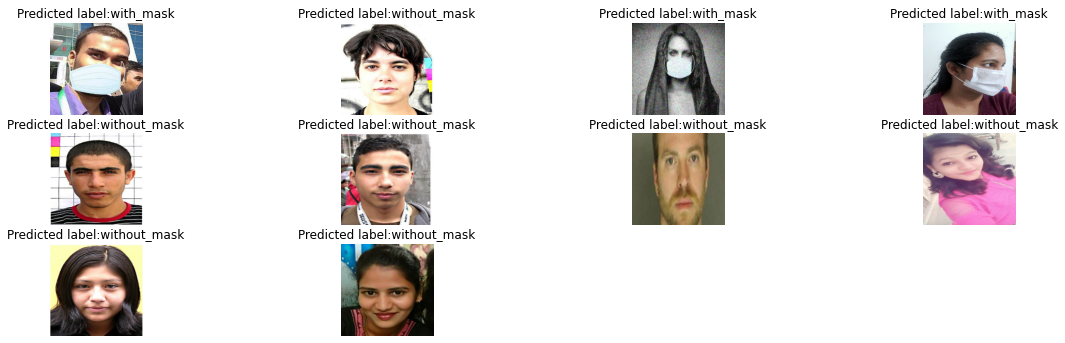

In [40]:
plt.figure(figsize=(20, 20))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
    
    for i in range(10):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:'+ predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [41]:
model.save("model_filter.h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
import json
import cv2
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

#load model
model = model_from_json(open("./model.json", "r").read())
#load weights
model.load_weights('./model_filter.h5')

face_haar_cascade = cv2.CascadeClassifier('../input/maskdataset/haarcascade_frontalface_default.xml')
cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(200,200))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

                #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('with mask','without mask')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)
    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows